# Algorithmic Feedback Synthesis for Robust Strong Invariance of Continous Control Systems

In [ ]:
from sympy import Array, symbols, lambdify
import numpy as np
x1, x2, x3 = symbols('x1 x2 x3')
a1 = Array([x1 + x3, x2 + x3, x1**2])
a2 = Array(np.zeros(3))
print(a2)
print(5*a1)
print(a1 + a2)
f = lambdify([x1, x2, x3], a1, 'numpy')
print(a1.__class__)
print(f.__class__)
lmao = (1,2,3)
print(*lmao)
print(f(*lmao).__class__)
print(f(*lmao))

[0.0, 0.0, 0.0]
[5*x1 + 5*x3, 5*x2 + 5*x3, 5*x1**2]
[x1 + x3, x2 + x3, x1**2]
<class 'sympy.tensor.array.dense_ndim_array.ImmutableDenseNDimArray'>
<class 'function'>
1 2 3
<class 'numpy.ndarray'>
[4 5 1]


In [ ]:
#@title Install Required Libraries
%%capture
!pip install pygad
!pip install gradient_free_optimizers
!pip install line_profiler
%load_ext line_profiler

# The link below can be referred for more information about profiling the code line by line
# https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/01.07-Timing-and-Profiling.ipynb#scrollTo=lRMD7pePczP1
# https://stackoverflow.com/questions/70303330/how-can-i-do-lprun-work-on-nested-function-in-python

In [ ]:
#@title Parameters
import numpy as np
from sympy import Array, symbols, lambdify

check_list = ["Warnings", "1.Check Gradient Initial Guess Function for more complicated situations", \
              "2. Check if lambdify works perfectly well"]
# Problem Parameters
problem_dict = {1: "Moore Greitzer",\
                2: "Rigid Body Motion"}
problem = problem_dict[2]
if problem == problem_dict[1]:
        ellipsoid_constants = np.array([0.2, 0.15])
        ellipsoid_centre = np.array([0.05, -0.06])
        max_noise = 0
        dim_v = 2
        dim_m = 1
        max_degree = 1
        # len_dict = dim_m*(max_degree + 1)**dim_v
        eta_bound = 100
        u_max_norm = 5
        print_point = 1
        EPSILON_HAMILTONIAN = 1E-2
        MAX_VAL = 10e8
        mv_indices = {1:2}
elif problem == problem_dict[2]:
        ellipsoid_constants = np.array([0.3, 0.2, 0.3])
        ellipsoid_centre = np.array([0.1, 0, 0.1])
        max_noise = 0
        dim_v = 3
        dim_m = 2
        max_degree = 1
        # len_dict = dim_m*(max_degree + 1)**dim_v
        eta_bound = 100
        u_max_norm = 5
        print_point = 1
        EPSILON_HAMILTONIAN = 1e-3
        MAX_VAL = 10e8
        mv_indices = {1:1, 2:2}
#Derived parameters
number_of_mesh_points = 10

#Inner Minimization Parameters
method_innermin = 'SLSQP'
minimization_tol = 1e-3
inner_min_exponent = 2
utol = 'ftol' if method_innermin == 'SLSQP' else 'tol'



In [ ]:
#@title Dictionary Zoo
import numpy as np
from sympy import Array, symbols, lambdify
x1, x2, x3 = symbols('x1 x2 x3')
raw_dict = {
    0:Array([1, 0]), \
    1:Array([0, 1]), \
    2:Array([x1, 0]), \
    3:Array([0, x1]), \
    4:Array([x2, 0]), \
    5:Array([0, x2]),\
    6:Array([x3, 0]), \
    7:Array([0, x3])
}

lambdified_dict = {}

for key in raw_dict.keys():
  lambdified_dict[key] = lambdify([x1, x2, x3], raw_dict[key], 'numpy')

In [ ]:
#@title Derived Parameters

len_dict = len(lambdified_dict)
dim_theta = len_dict*(dim_v - 1)
max_bound_array = 2* np.pi*np.ones(dim_theta)
min_bound_array = np.zeros(dim_theta)
bounds_array = (min_bound_array, max_bound_array)

kwargs={"ellipsoid_constants" : ellipsoid_constants,\
        "ellipsoid_centre": ellipsoid_centre, \
        "max_noise": max_noise,\
        "raw_dict": raw_dict,\
        "lambdified_dict": lambdified_dict,\
        "len_dict": len_dict,\
        "dim_v" : dim_v,\
        "dim_m": dim_m, \
        "max_degree": max_degree,\
        "u_max_norm": u_max_norm,\
        "eta_bound" : eta_bound,\
        "print_point" : print_point}


#GA Parameters
num_genes = dim_theta
num_generations = 50
sol_per_pop = 500
mutation_probability = 0.01
num_parents_mating = sol_per_pop
keep_elitism = 1
GA_low_bound = 0
GA_high_bound = 2*np.pi
parent_selection_type = 'sss'

#Plotting Parameters
discretization = {1:100, 2:50, 3:10}
k_discrete = discretization[dim_v]

In [ ]:
#@title Genetic Algorithm Functions
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation, rc
import pygad
import time

def fitness_func(ga_instance, solution, solution_idx):
    """Higher-level method to compute the fitness value of the chromosome
    Inputs
    ------
    The instance of the GA, the solution that is passed, the index of the solution
    Returns
    -------
    A scalar which is the fitness of the chromosome
    """
    fitness_value, _ = optimize_program_when_x_is_ellipsoid(solution, **kwargs)
    return fitness_value


fitness_function = fitness_func

def on_gen(ga_instance):
    print("Generation : ", ga_instance.generations_completed)


In [ ]:
#@title Forward Modelling
import numpy as np
from scipy.optimize import minimize
import time


def forward_model_theta_to_y(theta_flat, len_dict, dim_v, ellipsoid_constants, ellipsoid_centre):
  theta_reshape = theta_flat.reshape((len_dict, (dim_v - 1)))
    # Inputs: 1. Theta_flat, a numpy array of length |D|*(v - 1)
    #         2. len_dict = size of the dictionary = |D|
    #         3. dim_v = dimension of the v-space
    #         4. ellipsoid_constants, an  array of length v, which defines the ellipsoid's axis constants
    #         5. ellipsoid_centre, an array of length v, which defines the ellipse's center
    # Hidden: Theta_reshape, obtained by reshaping theta_flat to (|D|, v - 1)
    # Output: y, an array of size (|D|, v), obtained by using the forward model to switch from polar to Cartesian coordinates
  #Computing y
  y = np.ones((len_dict, dim_v))
  for d in range(0, len_dict):
    y[d] *= ellipsoid_constants
    for i in range(0, dim_v):
      if i < (dim_v - 1):
        for j in range(0, i):
          y[d][i] *= np.sin(theta_reshape[d][j])
        y[d][i] *= np.cos(theta_reshape[d][i])
      if i == (dim_v - 1):
        for j in range(0, i):
          y[d][i] *= np.sin(theta_reshape[d][j])
    y[d] += ellipsoid_centre
  #Computing grad_y
  grad_y = np.ones((len_dict, dim_v))
  for d in range(0, len_dict):
    grad_y[d] *= 2*(y[d] - ellipsoid_centre)/(ellipsoid_constants**2)
    norm_grad = np.linalg.norm(grad_y[d])
    grad_y[d] = grad_y[d]/norm_grad
  return y, grad_y


def compute_x_dot_noisy(y_array, y_norm_grad, feedback, dim_v, dim_m, max_noise, k):
  #Problem dependent part

  if problem == 'Moore Greitzer':
    f_array = np.zeros(dim_v)
    f_array[0] = -y_array[k][1] - 1.5*y_array[k][0]**2 -0.5*y_array[k][0]**3
    f_array[1] = 0
    g_matrix = np.array([[0], [1]])
    g_array = np.dot(g_matrix, feedback)
    w  = max_noise * y_norm_grad[k]
    h_array = np.array([[0, 1], [0, 0]])
    w_array = np.dot(h_array, w)

  elif problem == 'Rigid Body Motion':
    f_array = np.zeros(dim_v)
    f_array[0] = 0
    f_array[1] = 0
    f_array[2] = y_array[k][0]*y_array[k][1]
    g_matrix = np.array([[1, 0], [0, 1], [0, 0]])
    g_array = np.dot(g_matrix, feedback)
    w  = max_noise * y_norm_grad[k]
    h_array = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0]])
    w_array = np.dot(h_array, w)

  return f_array + g_array + w_array

In [ ]:
#@title Inner Minimization Assuming Ellipsoidal $\mathbb{X}$
import numpy as np
from scipy.optimize import minimize
import time
#import gradient_free_optimizers as gradfree

def optimize_program_when_x_is_ellipsoid(theta_array,  \
                                         ellipsoid_constants, ellipsoid_centre,\
                                          max_noise, raw_dict, lambdified_dict, len_dict, dim_v, \
                                            dim_m, max_degree, u_max_norm, \
                                              eta_bound, print_point = 0):
    start_time_in = time.time()
    y, y_norm_grad = forward_model_theta_to_y(theta_array, len_dict, dim_v, ellipsoid_constants, ellipsoid_centre)
    dimension_d = len_dict

    def objective_function(x):
      global num_obj_computations
      sum = 0
      for i in range(0, len(x)):
        sum += np.abs(x[i]**inner_min_exponent)
      return sum

    def bounds_function(i):
        return (None, None)

    def constraint_function1(x, k):
      feedback = np.zeros(dim_m)
      for i in range(len(x)):
        feedback = feedback + x[i]*lambdified_dict[i](*y[k])
      x_dot_noisy = compute_x_dot_noisy(y, y_norm_grad, feedback, dim_v, dim_m, max_noise, k)
      return np.dot(y_norm_grad[k], x_dot_noisy) + EPSILON_HAMILTONIAN

    bounds = [bounds_function(i) for i in range(0, len_dict)]

    constraint_functions1 = [lambda x, k=k: -constraint_function1(x, k) for k in range(dimension_d)]

    constraints = [{'type': 'ineq', 'fun': func} for func in constraint_functions1]

    initial_guess = [0]*len_dict

    result = minimize(objective_function, initial_guess, method=method_innermin, bounds=bounds, constraints=constraints, \
                      options={'disp': False,  utol: minimization_tol})
    end_time_in = time.time()
    #print(f"Inner Min took {end_time_in - start_time_in} seconds")
    if result.success == True:
      if print_point == 0:
        return result.fun
      elif print_point == 1:
        return result.fun, result.x
    elif result.success == False:
      if print_point == 0:
        return MAX_VAL
      elif print_point == 1:
        return MAX_VAL, result.x

In [ ]:
#@title Main Loop

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation, rc
import time
import datetime
# import three_d_naive_plotter

def main_loop():
  print(check_list)
  print("Solving the problem: ", problem)
  print("Length of the dictionary is: ", len_dict)
  print("Dimension of the problem is:", dim_theta)
  start_time = time.time()
  #print(compute_objective_function_on_mesh())

  ##GA
  ga_instance = pygad.GA(num_generations=num_generations,
                      num_parents_mating=num_parents_mating,
                      fitness_func=fitness_function,
                      sol_per_pop=sol_per_pop,
                      num_genes=num_genes,
                      parent_selection_type=parent_selection_type,
                      init_range_low=GA_low_bound,
                      init_range_high=GA_high_bound,
                      keep_elitism = keep_elitism,
                      gene_space=None,
                      save_solutions=True,
                      save_best_solutions = True,
                      mutation_type="random",
                      mutation_probability=mutation_probability,
                      on_generation=on_gen,
                      suppress_warnings=True)


  ga_instance.run()
  end_time = time.time()
  runtime_total = end_time - start_time
  runtime_per_loop = runtime_total/num_generations
  runtime_per_organism = runtime_per_loop/sol_per_pop
  ga_instance.plot_fitness()
  # ga_instance.plot_genes()
  # ga_instance.plot_new_solution_rate()

  solution, solution_fitness, solution_idx = ga_instance.best_solution(ga_instance.last_generation_fitness)
  _ , eta_psi_solution = optimize_program_when_x_is_ellipsoid(solution, **kwargs)
  optimal_symbolic_feedback = Array(np.zeros(dim_m))
  for i in range(len(eta_psi_solution)):
    optimal_symbolic_feedback = optimal_symbolic_feedback + eta_psi_solution[i]*raw_dict[i]
  print(f"Parameters of the best solution : {solution}")
  print(f"Fitness value of the best solution = {solution_fitness}")
  print(f"The optimal feedback obtained is = {optimal_symbolic_feedback}")

  print(f"Runtime Statistics. \n Total = {runtime_total}. \n \
        Per Generation = {runtime_per_loop}. \n \
        Per Organism = {runtime_per_organism}")

['Warnings', '1.Check Gradient Initial Guess Function for more complicated situations', '2. Check if lambdify works perfectly well']
Solving the problem:  Rigid Body Motion
Length of the dictionary is:  8
Dimension of the problem is: 16
Generation :  1
Generation :  2
Generation :  3
Generation :  4
Generation :  5
Generation :  6
Generation :  7
Generation :  8
Generation :  9
Generation :  10
Generation :  11
Generation :  12
Generation :  13
Generation :  14
Generation :  15
Generation :  16
Generation :  17
Generation :  18
Generation :  19
Generation :  20
Generation :  21
Generation :  22
Generation :  23
Generation :  24
Generation :  25
Generation :  26
Generation :  27
Generation :  28
Generation :  29
Generation :  30
Generation :  31
Generation :  32
Generation :  33
Generation :  34
Generation :  35
Generation :  36
Generation :  37
Generation :  38
Generation :  39
Generation :  40
Generation :  41
Generation :  42
Generation :  43
Generation :  44
Generation :  45
Generat

Generation :  50


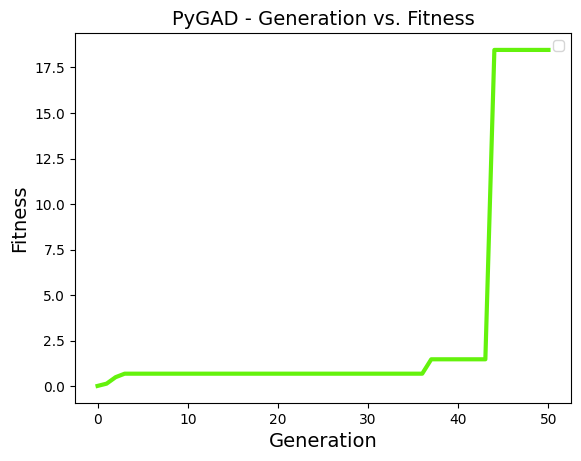

Parameters of the best solution : [4.16826328 5.00156197 1.15859575 0.27479765 1.56407516 1.52523536
 0.98405652 6.0073201  6.47647413 4.12078893 4.6973502  4.72950741
 5.59054186 4.43542527 1.56523745 1.58695479]
Fitness value of the best solution = 18.45844889677427
The optimal feedback obtained is = [-0.493819823950353*x1 - 0.419905317621391*x2 + 0.018100424606179*x3 + 0.0294546485780221
 -0.938560249935154*x1 - 4.14002526643453*x2 + 0.111776600812792*x3 + 0.0622626920674656]
Runtime Statistics. 
 Total = 491.0850338935852. 
         Per Generation = 9.821700677871704. 
         Per Organism = 0.019643401355743408
['Warnings', '1.Check Gradient Initial Guess Function for more complicated situations', '2. Check if lambdify works perfectly well']
Solving the problem:  Rigid Body Motion
Length of the dictionary is:  8
Dimension of the problem is: 16
Generation :  1
Generation :  2
Generation :  3
Generation :  4
Generation :  5
Generation :  6
Generation :  7
Generation :  8
Generation

Generation :  50


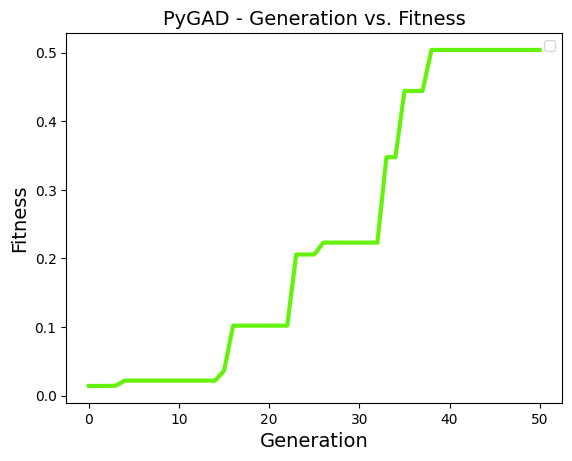

Parameters of the best solution : [1.59894428 1.55987658 1.54147314 1.16435403 1.71414007 4.80602257
 3.99639767 6.23798513 4.01429121 5.06243538 4.74044475 4.01387785
 5.7392618  1.71693243 4.73344034 1.55586955]
Fitness value of the best solution = 0.5039183029818001
The optimal feedback obtained is = [-0.439694848843419*x1 + 0.17401282204348*x2 - 0.0257052825500276*x3 + 0.128580416568414
 0.396273366466247*x1 - 0.203339485423943*x2 - 0.249964009669124*x3 + 0.0474453595002788]
Runtime Statistics. 
 Total = 491.4893219470978. 
         Per Generation = 9.829786438941955. 
         Per Organism = 0.01965957287788391
['Warnings', '1.Check Gradient Initial Guess Function for more complicated situations', '2. Check if lambdify works perfectly well']
Solving the problem:  Rigid Body Motion
Length of the dictionary is:  8
Dimension of the problem is: 16
Generation :  1
Generation :  2
Generation :  3
Generation :  4
Generation :  5
Generation :  6
Generation :  7
Generation :  8
Generation 

Generation :  50


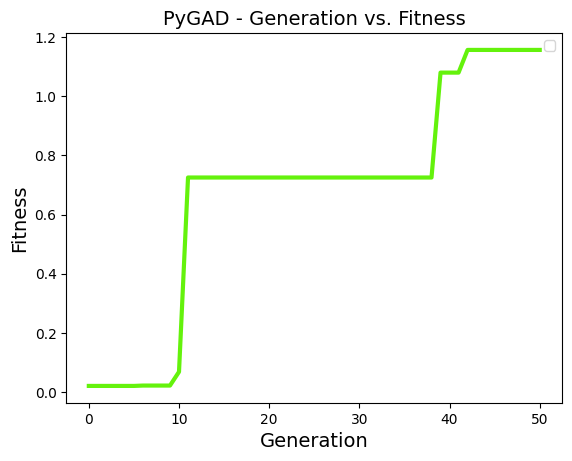

Parameters of the best solution : [3.80388047 1.47776612 0.60954201 0.36510191 5.24577371 1.80243606
 2.62133119 4.89892688 5.86689082 3.65297904 4.70838284 1.56847514
 1.21170006 1.3703222  4.60936642 1.63083473]
Fitness value of the best solution = 1.1564494781422336
The optimal feedback obtained is = [-0.849410958556866*x1 - 0.207293020397234*x2 - 0.293089607229703*x3 + 0.150641156637053
 -0.450134719359287*x1 - 0.136752512474673*x2 - 0.188618609477727*x3 + 0.162746226681942]
Runtime Statistics. 
 Total = 497.9146337509155. 
         Per Generation = 9.95829267501831. 
         Per Organism = 0.01991658535003662
['Warnings', '1.Check Gradient Initial Guess Function for more complicated situations', '2. Check if lambdify works perfectly well']
Solving the problem:  Rigid Body Motion
Length of the dictionary is:  8
Dimension of the problem is: 16
Generation :  1
Generation :  2
Generation :  3
Generation :  4
Generation :  5
Generation :  6
Generation :  7
Generation :  8
Generation :

Generation :  50


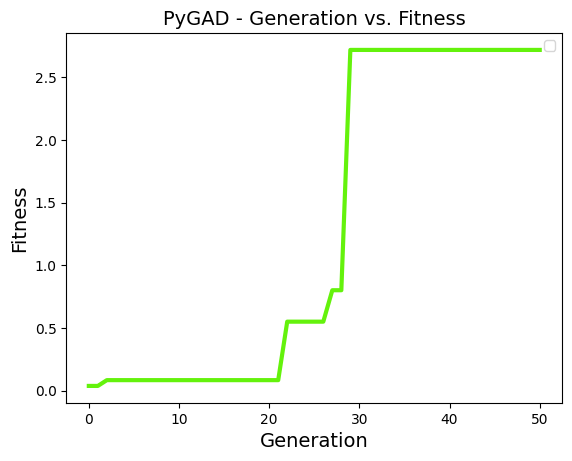

Parameters of the best solution : [4.70827218 0.85134989 4.69892657 4.73745148 5.00173854 4.97377791
 1.54481995 1.63838791 2.22890655 3.6625986  1.73580694 4.82474167
 0.88838496 4.04378779 1.53854721 1.50756651]
Fitness value of the best solution = 2.7200526572332913
The optimal feedback obtained is = [-0.465427041214328*x1 - 0.350088286303345*x2 + 0.0714514917901358*x3 + 0.0484262662898057
 -0.780523875620753*x1 - 1.32628461741992*x2 - 0.00469437071160723*x3 + 0.0717471633726975]
Runtime Statistics. 
 Total = 502.82924032211304. 
         Per Generation = 10.056584806442261. 
         Per Organism = 0.02011316961288452
['Warnings', '1.Check Gradient Initial Guess Function for more complicated situations', '2. Check if lambdify works perfectly well']
Solving the problem:  Rigid Body Motion
Length of the dictionary is:  8
Dimension of the problem is: 16
Generation :  1
Generation :  2
Generation :  3
Generation :  4
Generation :  5
Generation :  6
Generation :  7
Generation :  8
Gener

Generation :  50


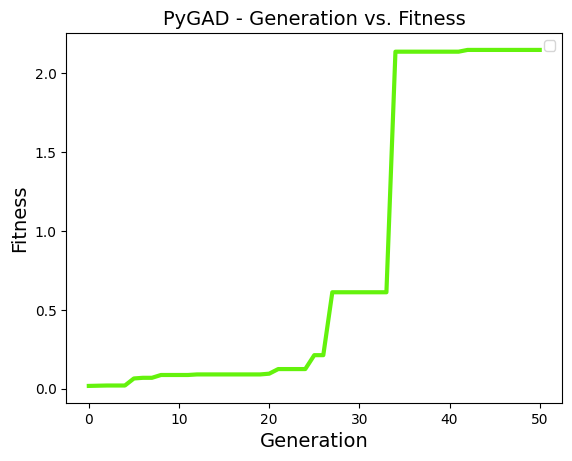

Parameters of the best solution : [4.67622099 1.59894667 5.38567104 2.80586961 0.78971781 4.48816189
 0.94114417 4.22489266 1.55434181 4.68542125 4.09012287 1.32645361
 4.70605273 1.52557672 1.37620048 4.76056698]
Fitness value of the best solution = 2.147991141571322
The optimal feedback obtained is = [-1.31194325361502*x1 + 0.142578478882726*x2 - 0.115229688985799*x3 + 0.161524446692568
 0.3220674059311*x1 - 0.511369119855578*x2 - 0.0413927618299236*x3 + 0.0126585419687444]
Runtime Statistics. 
 Total = 505.3927927017212. 
         Per Generation = 10.107855854034424. 
         Per Organism = 0.020215711708068847
['Warnings', '1.Check Gradient Initial Guess Function for more complicated situations', '2. Check if lambdify works perfectly well']
Solving the problem:  Rigid Body Motion
Length of the dictionary is:  8
Dimension of the problem is: 16
Generation :  1
Generation :  2
Generation :  3
Generation :  4
Generation :  5
Generation :  6
Generation :  7
Generation :  8
Generation :

Generation :  50


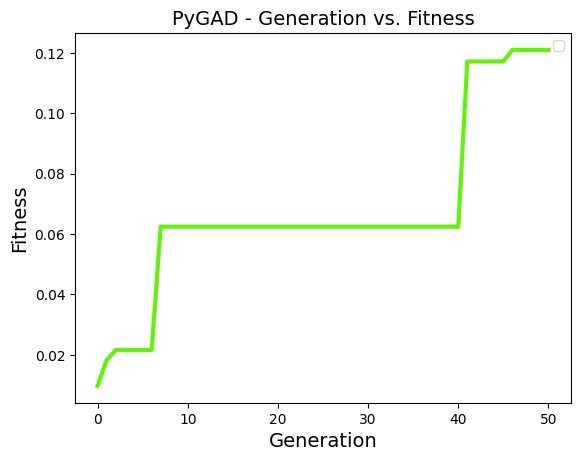

Parameters of the best solution : [1.53911834 1.55547079 6.01945322 1.03639724 2.93780194 2.26247121
 2.33830116 1.67313687 4.7892655  3.7131238  2.02356903 1.53766853
 1.18116494 0.93969616 1.84428056 1.73888319]
Fitness value of the best solution = 0.12101175228529602
The optimal feedback obtained is = [-0.272775724161143*x1 - 0.0802465351605566*x2 - 0.043921798359995*x3 + 0.0118207574804398
 -0.178575402995316*x1 - 0.0730844660450003*x2 - 0.02178347216314*x3 + 0.0197929815412847]
Runtime Statistics. 
 Total = 503.5399649143219. 
         Per Generation = 10.070799298286438. 
         Per Organism = 0.020141598596572878
['Warnings', '1.Check Gradient Initial Guess Function for more complicated situations', '2. Check if lambdify works perfectly well']
Solving the problem:  Rigid Body Motion
Length of the dictionary is:  8
Dimension of the problem is: 16
Generation :  1
Generation :  2
Generation :  3
Generation :  4
Generation :  5
Generation :  6
Generation :  7
Generation :  8
Gener

Generation :  50


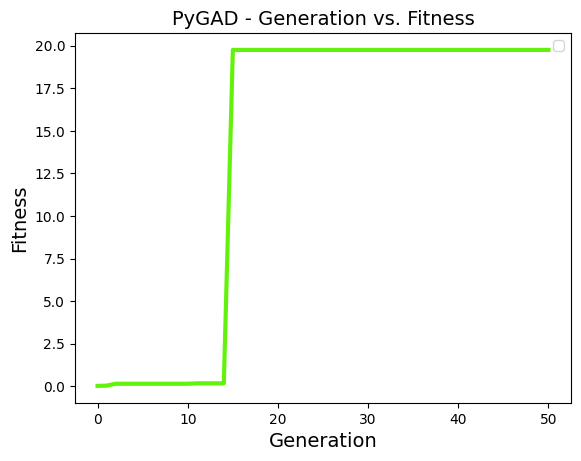

Parameters of the best solution : [1.55921876 4.68792292 1.61526032 4.7097228  0.89722566 2.94505995
 2.42565735 5.21611918 5.49798636 2.08641444 2.7188863  2.24055574
 5.75500938 0.45255785 4.72764124 1.59358632]
Fitness value of the best solution = 19.752838164377838
The optimal feedback obtained is = [-3.56671499005656*x1 - 0.274318668492484*x2 - 0.0265762538150445*x3 + 0.324648756132706
 -0.609495993855575*x1 - 2.54409488341478*x2 - 0.0127638654647348*x3 + 0.0772103715180368]
Runtime Statistics. 
 Total = 512.2603576183319. 
         Per Generation = 10.245207152366639. 
         Per Organism = 0.02049041430473328
['Warnings', '1.Check Gradient Initial Guess Function for more complicated situations', '2. Check if lambdify works perfectly well']
Solving the problem:  Rigid Body Motion
Length of the dictionary is:  8
Dimension of the problem is: 16
Generation :  1
Generation :  2
Generation :  3
Generation :  4
Generation :  5
Generation :  6
Generation :  7
Generation :  8
Generatio

Generation :  50


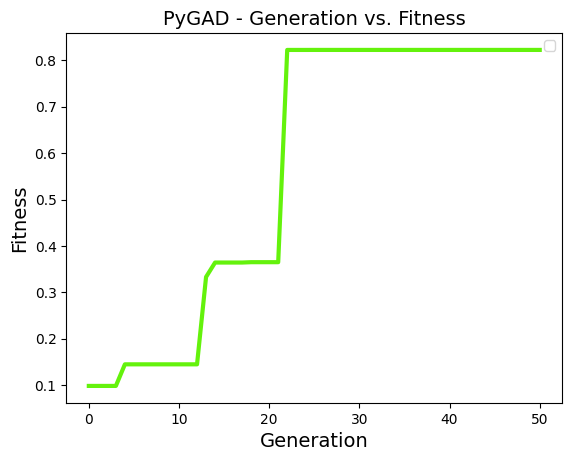

Parameters of the best solution : [1.52995517 4.71378189 0.59875728 2.1555184  5.93087237 1.2040099
 1.67010279 4.74544841 4.23483909 3.97880912 4.69997988 1.48894193
 4.79485612 1.33038763 5.03903268 4.24349783]
Fitness value of the best solution = 0.8223714417075351
The optimal feedback obtained is = [-0.832093854217786*x1 + 0.10476588612143*x2 + 0.0111906929114971*x3 + 0.0707521636220261
 0.23510907599933*x1 - 0.241828674380858*x2 - 0.00944255920407095*x3 - 0.00614174456443232]
Runtime Statistics. 
 Total = 497.82784485816956. 
         Per Generation = 9.956556897163392. 
         Per Organism = 0.019913113794326785
8min 21s ± 6.18 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# %lprun -f main_loop main_loop()
%%timeit
main_loop()

In [ ]:
#@title Old Two Dimensional Plotter
'''
https://matplotlib.org/2.0.2/examples/mplot3d/surface3d_demo2.html
'''
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib.tri import Triangulation

max_noise2 = 3*1e-2

def ellipse_params(c1, c2, a1, a2, theta):
    x1 = c1 + a1 * np.cos(theta)
    x2 = c2 + a2 * np.sin(theta)
    return x1, x2

# Function to compute f1 and f2
def compute_f(c1, c2, a1, a2, theta):
    x1, x2 = ellipse_params(c1, c2, a1, a2, theta)
    dir1 = compute_normal(theta,a1,a2)[1]
    f1 = -x2 - 1.5*x1**2 - 0.5*x1**3 + max_noise2*np.random.random()*dir1
    f2 = 0# Define your function here based on x1 and x2
    return f1, f2

# Function to compute g1 and g2
def compute_g(c1, c2, a1, a2, theta):
    x1, x2 = ellipse_params(c1, c2, a1, a2, theta)
    g1 = 0
    #g2 =  -0.00331751964229724*x1*x2 + 4.7127329059459e-7*x1 - 427.583943014243*x2 - 23.4117086141303
    g2 = -0.0101605661916929*x1**2*x2**2 - 0.0183849712109924*x1**2*x2 + 0.0416923597998396*x1**2 \
- 0.00762162947104746*x1*x2**2 - 0.0360783749974401*x1*x2 + 0.39076185567161*x1 + 0.00203063048874425*x2**2 - 0.177218411665688*x2 - 0.0141966167620039
    return g1, g2
# Function to compute the normal vector

def compute_normal(theta, a1, a2):
    normal = np.array([np.cos(theta)/a1, np.sin(theta)/a2])
    unit_normal = normal/np.abs(np.linalg.norm(normal))
    return unit_normal


# Function to compute angle between two vectors
c1, c2 = ellipsoid_centre[0], ellipsoid_centre[1]
a1, a2 = ellipsoid_constants[0], ellipsoid_constants[1]
l_bound = 0*np.pi
u_bound = 2*np.pi
n_samples_low = 10
n_samples_high = 100
theta_values_ellipse = np.linspace(l_bound,u_bound, n_samples_high)
theta_values = np.linspace(l_bound,u_bound, n_samples_low)
theta_values_high_res = np.linspace(l_bound, u_bound, n_samples_high)


# Plotting
print("Solving the problem: ", problem)
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
scaling_factor_f = 1
scaling_factor_g = 1
scaling_factor_fg = 1


axs[0, 0].set_title('Drift Vector Field')
x1, x2 = ellipse_params(c1, c2, a1, a2, theta_values)
x1e, x2e = ellipse_params(c1, c2, a1, a2, theta_values_ellipse)
axs[0, 0].plot(x1e, x2e, label='Ellipse', linewidth  = 3)
f1, f2 = compute_f(c1, c2, a1, a2, theta_values)
quiver = axs[0, 0].quiver(x1, x2, f1, f2, color='r', \
                          scale=1/scaling_factor_f, label='Vector Field')
axs[0, 0].set_aspect('equal')  # Set aspect ratio to ensure proper ellipse representation
axs[0, 0].legend()

axs[0, 1].set_title('Control Vector Field')
axs[0, 1].plot(x1e, x2e, label='Ellipse', linewidth  = 3)
g1, g2 = compute_g(c1, c2, a1, a2, theta_values)
quiver = axs[0, 1].quiver(x1, x2, g1*scaling_factor_g , g2*scaling_factor_g, \
                          color='b', scale=1/scaling_factor_g, label='Additional Vector Field')
axs[0, 1].set_aspect('equal')
axs[0, 1].legend()

axs[1, 0].set_title('Resultant Vector Field')
axs[1, 0].plot(x1e, x2e, label='Ellipse', linewidth  = 3, color = 'r')
quiver = axs[1, 0].quiver(x1, x2, (f1 + g1)*scaling_factor_fg, \
                          (f2 + g2)*scaling_factor_fg\
                          , color='g', scale=1/scaling_factor_fg, label='Resultant Vector Field'\
                )
normals = compute_normal(theta_values, a1, a2)
quiver = axs[1, 0].quiver(x1, x2, normals[0]*scaling_factor_fg, (normals[1])*scaling_factor_fg\
                          , color='b', scale=1/scaling_factor_fg)
axs[1, 0].set_aspect('equal')
axs[1, 0].legend()

dot_products = np.zeros_like(theta_values_high_res)
i = 0
for theta in theta_values_high_res:
  normal = compute_normal(theta, a1, a2)
  f1, f2 = compute_f(c1, c2, a1, a2, theta)
  g1, g2 = compute_g(c1, c2, a1, a2, theta)
  dot_product = ((f1 + g1)*normal[0] + (f2 + g2)*normal[1])/np.sqrt((f1 + g1)**2 + (f2 + g2)**2) \
  if np.sqrt((f1 + g1)**2 + (f2 + g2)**2) > 0 else 0
  dot_products[i] = dot_product
  i += 1
print(max(dot_products))


axs[1,1].set_title('Normalized Dot Product (Cosine()) as a Function of theta')
axs[1,1].plot(theta_values_high_res, dot_products, color='blue', label='Scatter Plot')
plt.axhline(0, color='red', linestyle='--', label='y=0')

plt.show()

In [ ]:
#@title New Two Dimensional Naive Plotter
'''
https://matplotlib.org/2.0.2/examples/mplot3d/surface3d_demo2.html
'''
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib.tri import Triangulation

c1, c2 = ellipsoid_centre[0], ellipsoid_centre[1]
a1, a2 = ellipsoid_constants[0], ellipsoid_constants[1]

n_samples = 200

theta1 = np.linspace(0, 2 * np.pi, n_samples)
x1 = np.ravel(c1 + a1 * np.cos(theta1))
x2 = np.ravel(c2 + a2 * np.sin(theta1))

n1 = (x1 - c1)/a1**2
n2 = (x2 - c2)/a2**2
n_norm = np.sqrt(n1**2 + n2**2) + 1e-8

f1 = -x2 - 1.5*x1**2 - 0.5*x1**3
f2 = 0*x1

g1 = 0
g2 = -n2

z1, z2 = 1, 1
h1 = f1 + z1*g1
h2 = f2 + z2*g2

h_norm =  np.sqrt(h1**2 + h2**2) + 1e-8


dot_product = (h1*n1 + h2*n2)/(n_norm*h_norm)
print("Average dot product: ", dot_product.mean())
print("Worst case dot product: ", dot_product.max())


fig = plt.figure(figsize=plt.figaspect(0.5))

ax = fig.add_subplot(1, 2, 1)
ax.plot(x1, x2, color='black', alpha = 0.9);
skip = 4
ax.quiver(x1[::skip], x2[::skip], h1[::skip], h2[::skip],  color = 'red')
ax1 = fig.add_subplot(1, 2, 2)
pcm = ax1.scatter(x1,x2, cmap='jet',c=dot_product)
plt.colorbar(pcm, ax = ax1)
plt.show()


In [ ]:
#@title Three Dimensional Plotter
'''
https://matplotlib.org/2.0.2/examples/mplot3d/surface3d_demo2.html
'''
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib.tri import Triangulation
%matplotlib inline

c1, c2, c3 = ellipsoid_centre[0], ellipsoid_centre[1], ellipsoid_centre[2]
a1, a2, a3 = ellipsoid_constants[0], ellipsoid_constants[1], ellipsoid_constants[2]

n_samples = 50
theta1 = np.linspace(0, 2 * np.pi, n_samples)
theta2 = np.linspace(0, 2 * np.pi, n_samples)
theta1, theta2 = np.meshgrid(theta1, theta2)
x1 = np.ravel(c1 + a1 * np.cos(theta1)*np.cos(theta2))
x2 = np.ravel(c2 + a2 * np.cos(theta1)*np.sin(theta2))
x3 = np.ravel(c3 + a3 * np.sin(theta1))

n1 = (x1 - c1)/a1**2
n2 = (x2 - c2)/a2**2
n3 = (x3 - c3)/a3**2
n_norm = np.sqrt(n1**2 + n2**2 + n3**2) + 1e-8

f1 = 0*x1
f2 = 0*x2
f3 = x1*x2


g1 = -0.0202303895217493*x1*x2*x3 - 0.0526334140408877*x1*x2 - 0.278540519252498*x1*x3 - 0.805573044937123*x1 - 0.083641799386621*x2*x3 - 0.220293374036381*x2 + 0.305963401768784*x3 + 0.135966082916927
g2 =  -0.0669317833494864*x1*x2*x3 - 0.171474222377031*x1*x2 - 0.178201648956155*x1*x3 - 0.494379950390592*x1 - 0.579202048680921*x2*x3 - 1.43699589859309*x2 + 0.0999225639975492*x3 + 0.0127995093290149
g3 = 0

# g1 = -n1
# g2 = -n2
# g3 = 0

z1, z2, z3 = 1, 1, 1
h1 = f1 + z1*g1
h2 = f2 + z2*g2
h3 = f3 + z3*g3
h_norm =  np.sqrt(h1**2 + h2**2 + h3**2) + 1e-8


dot_product = (h1*n1 + h2*n2 + h3*n3)/(n_norm*h_norm)
print("Average dot product: ", dot_product.mean())
print("Worst case dot product: ", dot_product.max())

tri = Triangulation(np.ravel(theta1), np.ravel(theta2))

fig = plt.figure(figsize=plt.figaspect(0.5))

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_trisurf(x1, x2, x3, triangles=tri.triangles, cmap='jet', linewidths=0.2, alpha = 0.1);
skip = 4
ax.quiver(x1[::skip], x2[::skip], x3[::skip], h1[::skip], h2[::skip], h3[::skip], \
        length=0.1, normalize=True, color = 'red')
ax1 = fig.add_subplot(1, 2, 2, projection='3d')
pcm = ax1.scatter(x1,x2,x3,cmap='jet',c=dot_product)
plt.colorbar(pcm, ax = ax1)
plt.show()
